# Assignment 6: Appearance-based gaze estimation - Task 03

Author: `Yintao, Xu` | Date: `2020-02-15` | Email: xuyt@shanghaitech.edu.cn

Topics: `numpy`

**Note**: Make sure you have completed task 01 & 02.

HOG, as a feature engineering method, could improve your estimation performance.

![](figures/HOG_visual.png)

In [20]:
# IMPORTANT: run this cell before runnng any cell to activate auto re-import
%load_ext autoreload
%autoreload 2

# 'gazelib' is the toolkit provided by this assignment, at the same directory of this notebook
from gazelib.utils import *
import numpy as np
import time
import matplotlib.pyplot as plt
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of AppearanceGazeEst failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 669, in exec_module
  File "<frozen importlib._bootstrap_external>", line 775, in get_code
  File "<frozen importlib._bootstrap_external>", line 735, in source_to_code
  File "<frozen importlib._bootstrap>", line 222, in _call_with_frames_removed
  File "/root/homework-6/AppearanceGazeEst.py", line 334
    print(grad_mag)
        

In [21]:
# Datasets has been supposed to be downloaded at last notebook
# You could run thie cell to have a check :)
download_csv_mpIIdataset()

[GazeLib] Train csv has downloaded and passed md5 cheking.
[GazeLib] Test csv has downloaded and passed md5 cheking.


In [22]:
# load the training dataset
train_df = load_train_csv_as_df()
train_df.head(10)

,subject_id,yaw,pitch,image_base64
0,5,-0.202976,-0.300898,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,5,0.153875,-0.216009,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,6,-0.240222,-0.231348,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,6,0.082681,-0.148303,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,11,0.141780,-0.259967,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
5,14,0.089140,-0.223431,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
6,6,-0.052793,-0.056385,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
7,13,-0.275569,-0.115087,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
8,5,0.095293,-0.210037,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
9,2,-0.066253,-0.250547,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [23]:
# transform data into numpy arrays
def df2nptensor(df):
    imgs = []
    imgs_HOG = []
    gaze_dirs = []

    print_interval = 1000
    print_cnter = 0
    
    for _, i in df.iterrows():
        if print_cnter % print_interval == 0:
            print("[{} / {}]".format(print_cnter, len(df)), end='\r')
        print_cnter += 1
        im_arr = decode_base64_img(i['image_base64'])
        gaze_dirs.append([i['yaw'], i['pitch']])
        im = im_arr / 255
        
        imgs.append(im)
    
    gaze_dirs = np.array(gaze_dirs)
    imgs = np.array(imgs)
    
    return gaze_dirs, imgs

# For effciency, we only takes first 5,000 samples. Pick subject 5 as validation 
# set and the rest of the dataset as training set
SAMPLE_NUM = 5000
print("Start to generate sampled dataset, it may take ~10s.")
train_Y, train_X = df2nptensor(train_df[train_df["subject_id"] != 5][: int(SAMPLE_NUM * 0.8)])
val_Y, val_X = df2nptensor(train_df[train_df["subject_id"] == 5][: int(SAMPLE_NUM * 0.2)])

print("train_X.shape: {}".format(train_X.shape))
print("train_Y.shape: {}".format(train_Y.shape))
print("val_X.shape: {}".format(val_X.shape))
print("val_X.shape: {}".format(val_Y.shape))

Start to generate sampled dataset, it may take ~10s.
train_X.shape: (4000, 18, 30)
train_Y.shape: (4000, 2)
val_X.shape: (1000, 18, 30)
val_X.shape: (1000, 2)


## Roadmap

At previous sections, estimation pipeline for gaze vector has been built:

<img src="figures/gaze_model_pipeline.png" style="zoom:80%" />

Formalize the input/ouput of our estimation pipeline mathematically:
- `Input`: the gray-scale image $I\in \mathbb{R}^{18\times30}$ (18x30 numpy array)
- `Output`: two floats: yaw($\gamma \in \mathbb{R}$), pitch($\theta  \in \mathbb{R}$)


In previous sections, we have evaluated the simlarity among images by Euclidean distance. However, naive computation over raw image is computationally expensive.

## Section 3.0: Motivation: Why HOG? 


We have 42,000 images in our pandas data frame. Assume in each estimation, we require doing one float number multplication for each pixels in every image.

In [24]:
a = np.random.randn(42000 * 18 * 30,)
b = np.random.randn(42000 * 18 * 30,)

time_start = time.time()
c = a * b
time_end = time.time()

print("Multiply 42000 * 18 * 30 numbers cost: {:.4f}s".format(time_end - time_start))

Multiply 42000 * 18 * 30 numbers cost: 2.1214s


**Large computational cost**: It runs ~0.06 seconds on *Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz*, which sounds tractable. However, you may repeat 10,000 ~ 20,000 such operation, which means roughly that it will cost ~ 20 min. Besides, memory cost is also considerable. Therefore, we require a **dimension reduction** method to reduce the computation. 

**Not robust to translation**: If we apply Euclidean distance to images, when a slight translation of image occurs, it may lead to dramatic change to output.

In computer vision community, **HOG(histogram of oriented gradient)** is a frequently used method to do the feature engineering of images with tractable size of dimension and much robustness.

## Section 3.1: Gradient of Image [2]

There is a widely accepted assumption in computer vision community: 
> local object appearance and shape can often be characterized rather well by **the distribution of local intensity gradients or edge directions**, even without precise knowledge of the corresponding gradient or edge posistions.

Therefore, studying the **image gradient**[3] is important. It is a directional change in the intensity or color in an image. 

![](figures/HOG.png)

Mathematically, the gradient of a two-variables function (here the image intensity function) at each image point is a 2D vector with the components given by the derivatives in the horizontal and vertical directions.

An image in modern devices can be viewed as a matrix of pixel intensity, which is discrete. However, derivatives of this function cannot be defined unless we assume that there is an underlying continuous intensity function which has been sampled at the image points. 

The most common way to approximate the image gradient is to **convolve an image with a kernel**, such as the [**Sobel operator**](https://en.wikipedia.org/wiki/Sobel_operator).

Let's first start with **2D convolution**.

### Section 3.1.1: 2D Convolution[1] (15%)
Convolution is an important class of operators in linear time-invariant (LTI) system. You start with a **kernel**, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an element-wise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

![ChessUrl](http://data.liubai01.cn:81/f/c518901817914d7f815e/?dl=1 "chess") 

Formally, it is denoted as $*$:

$$
    \textbf{O} = \textbf{F} * \textbf{I}
$$

with $\textbf{O}$ corresponding to output, $\textbf{F}\in \mathbb{R}^{2K+1\times2K+1}$ corresponding to filter kernel, $\textbf{I}\in \mathbb{R}^{W \times H}$ corresponding to the input Image.

The formula can be written as follows:

$$
    \textbf{O}_{i,j} = \sum_{k=0}^{2K} \sum_{l=0}^{2K} \textbf{F}_{k,l} \times \textbf{I}_{k + i, l + j}, i \in [0, W -2], j \in [0, H - 2]
$$

For instance, for the upper-left corner of output value 12 at previous figure:

$$
    12 = 3 \times 0 + 3 \times 1 + 2 \times 2 + 0 \times 2 + 0 \times 2 + 1 \times 0 + 3 \times 0 + 1 \times 1 + 2 \times 2
$$

*Remark: For those who has background in signal & system, note the inconsistent meaning of "Conovolution" in mathematical(signal&system) context and machine learning context. In most cases, convolution in machine learning is the correlation in signal & system, which means you are not required to flip the kernel. It was a historical misnormer here, but is accepted by most scientists nowadays.*

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst/conv2d3x3`(15%)**

In [25]:
# Local Test - Section 3.1.1 (15%)
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import conv2d3x3
from gazelib.task_2_judge import assert_eq_np

img = np.array([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
])
kernel = np.array([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
])
gt_out = np.array([
    [12, 12, 17],
    [10, 17, 19],
    [9, 6, 14]
])

out = conv2d3x3(img, kernel)
assert_eq_np(gt_out, out)

print("Pass Section 3.1.1 - convolution 2d local test(15%).")

Pass Section 3.1.1 - convolution 2d local test(15%).


### Section 3.1.2: Compute Gradient By Sobel Operator (15%) - Apply convolution by numpy [4]
The Sobel operator is a discrete differentiation operator, computing an approximation of the gradient of the image intensity function.

The operator uses two 3×3 kernels which are convolved with the original image to calculate approximations of the derivatives – one for horizontal changes, and one for vertical. The 2D convolution has been implemented by previous sections. If we define I as the source image, and Gx and Gy are two images which at each point contain the vertical and horizontal derivative approximations respectively, the computations are as follows:

$$
\mathbf {G} _{x}={\begin{bmatrix}-1&0&1\\-2&0&2\\-1&0&1\end{bmatrix}}*\mathbf {I} \quad {\mbox{and}}\quad \mathbf {G} _{y}={\begin{bmatrix}-1&-2&-1\\0&0&0\\1&2&1\end{bmatrix}}*\mathbf {I}
$$

In most implementations, they also apply gaussian kernel to smooth the image before getting gradients.

![](figures/eye_grad_new.png)

Formally, for each pixel
$$
Mag = \sqrt{g _{x}^2 + g_{y}^2}
$$
$$
\mathbf{Dir} = [g _{x}; g_{y}]
$$
$$
\mathbf{Dir}_{norm} = \mathbf{Dir} / (Mag + 10^{-3})
$$
Here, 10e-3 is applied to improve numerical robustness in case of zero magnitude.

![](figures/code_time.png)
**Complete the code of the sobel gradient computation at `AppearanceGazeEst.py/compute_grad`(15%)**

In [26]:
# Local Test - Section 3.1.2 (15%)
# Note: feel free to print out your result to debug at gazelib.task_2_judge.py/assert_eq_2223
# if it cannot pass assert_eq_np
from AppearanceGazeEst import compute_grad
from gazelib.task_2_judge import assert_eq_2223

sanity_im = np.array([
    [1., 1., 7.], 
    [2., 1., 8.], 
    [3., 5., 2.]
])

grad_dir, grad_mag = compute_grad(sanity_im)
assert_eq_2223(grad_dir, grad_mag)
print("You pass the local test - Section 3.1.2 (15%)")

[[ 0.         10.25        0.        ]
 [ 4.25        8.86002257  0.75      ]
 [ 0.          6.75        0.        ]]
[[[0.         0.99990245 0.        ]
  [0.         0.95925723 0.        ]
  [0.         0.99985187 0.        ]]

 [[0.         0.         0.        ]
  [0.99976476 0.28213448 0.99866844]
  [0.         0.         0.        ]]]
You pass the local test - Section 3.1.2 (15%)


[[1.11022302e-16 2.06862745e-01 2.55392157e-01 2.93137255e-01
  3.26470588e-01 2.31372549e-01 1.42647059e-01 1.18137255e-01
  4.16666667e-02 4.41176471e-02 5.24509804e-02 4.85294118e-02
  1.08823529e-01 1.65686275e-01 2.03921569e-01 2.97058824e-01
  4.51960784e-01 5.39705882e-01 4.36274510e-01 3.19607843e-01
  3.59313725e-01 3.96078431e-01 3.14215686e-01 2.03921569e-01
  1.36764706e-01 1.03431373e-01 6.61764706e-02 2.45098039e-02
  5.88235294e-03 0.00000000e+00]
 [2.14705882e-01 3.47358489e-01 4.70116440e-01 5.79803955e-01
  6.53790830e-01 6.70642162e-01 7.38011726e-01 8.55785558e-01
  9.76237520e-01 1.08850051e+00 1.15667356e+00 1.16959228e+00
  1.16483069e+00 1.17110485e+00 1.20583876e+00 1.29477275e+00
  1.42610858e+00 1.51556864e+00 1.46266205e+00 1.32245713e+00
  1.18419776e+00 1.04591647e+00 8.75471052e-01 6.85387557e-01
  4.92290745e-01 3.31591651e-01 2.12075389e-01 1.32739541e-01
  9.48152507e-02 8.28431373e-02]
 [5.68137255e-01 6.81852878e-01 8.19603226e-01 8.99109143e-01
  9.

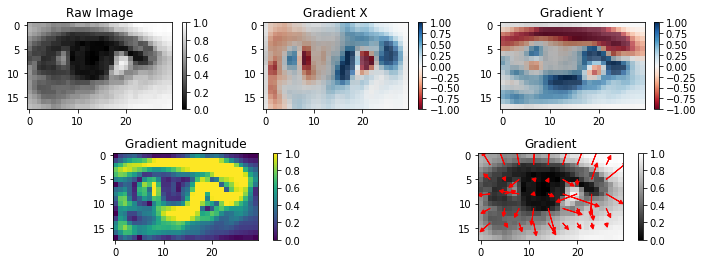

In [27]:
# sample an image to visualize the gradient computation
sample_im = train_X[random.randint(0, train_X.shape[0])]
gaze_dir, gaze_mag = compute_grad(sample_im)
vis.vis_grad(sample_im, gaze_dir[0] * gaze_mag, gaze_dir[1] * gaze_mag)

## Section 3.2 Histogram of oriented gradient (10%, Bonus 10%)
Recall in section 2.3:
> local object appearance and shape can often be characterized rather well by **the distribution of local intensity gradients or edge directions**, even without precise knowledge of the corresponding gradient or edge posistions.

When finishing computing of gradients, at next step, you should get the distribution over an image (or an image patch). Using histogram is an intuitive way to model a distribution with many weighted data points(gradients of pixels, with direction and magnitude). This step is called **Orientation Binning**.

### Section 3.2.1: Details of Orientation Binning (Optional Reading)

**Note**: You are not required to go to very details of Orientation Binning. We'll provide you with a reference code.

<img src="figures/hist_grad_vis.png_fix.png" style="zoom:60%" />

**Range of angle**[6] In this assignment, angles are derived from `np.arctan2` towards gradient direction(x1,x2), which means that it ranges from $[-\pi, +\pi]$.

![](figures/arctan2_wiki.png)

**Bilinear voting policy**[5] A bin is selected based on the direction, and the vote ( the value that goes into the bin ) is selected based on the magnitude. 

Let’s first focus on the pixel encircled in blue. It has an angle ( direction ) of 30 degrees and magnitude of 5. So it adds 5 to the 30-deg. bin. The gradient at the pixel encircled using red has an angle of -40 degrees and magnitude of 3. Since -40 degrees is between -60 and -30, the vote by the pixel splits into the two bins 
proportional to 1/dist. to the bin.

**Boundary condtion** When angle goes to boundary, for example, 160 degrees, it should be going to bin of 150-deg and -180-deg. Due to the range of `np.arctan2`, angle skips numerically at 180 and -180 but is adajacent at Cartesian coordination.

### Section 3.2.2: Numpy: vectorization [7]

Vectorization is used to speed up the Python code without using loop. Numpy will invokes C-code directly at backend, which is more rapid than python loops.

In [28]:
# Try this cell to see the power of vectorization
a = np.random.randn(100000,)
b = np.random.randn(100000,)

c = 0
# python loops
time_start = time.time()
for i in range(100000):
    c = a[i] + b[i]
time_nonvec = time.time() - time_start

# vectorization
time_start = time.time()
c_ = np.sum(a + b)
time_vec = time.time() - time_start

speed_up_per = (time_nonvec / time_vec - 1) * 100

print("Before vectorization: {:.3f} s".format(time_nonvec))
print("After vectorization: {:.3f} s".format(time_vec))
print("Speedup: {:.2f}%".format(speed_up_per))

Before vectorization: 0.050 s
After vectorization: 0.001 s
Speedup: 9253.83%


### Section 3.2.3: Re-implement HOG - learn vectorization at numpy(Bonus, 10%)

**Note**: the non-vectorized version is at `ApperanceGazeEstV2/bilinear_HOG_nonvec` above the target function `bilinear_HOG`. Please gaurantee that your implementation shares the same output as it and speeds up at least 200%.

![](figures/code_time.png)
**Complete the code of the HOG computation at `AppearanceGazeEst.py/bilinear_HOG`(10%)**

In [29]:
# Local Test - Section 3.2.3 (Bonus, 10%)
# Note: feel free to print out your result to debug at gazelib.task_2_judge.py/assert_eq_2223
# if it cannot pass assert_eq_np
from gazelib.HOG import bilinear_HOG_patch_nonvec
from AppearanceGazeEst import bilinear_HOG
import time

sample_im = train_X[5]
grad_dir, grad_mag = compute_grad(sample_im)
time_nonvec = 0
time_vec = 0
exp_num = 6

for _ in range(exp_num): # repeat experiments due to randomness of OS scheduling
    time_start = time.time()
    a = bilinear_HOG_patch_nonvec(gaze_dir, gaze_mag)
    time_nonvec += time.time() - time_start

    time_start = time.time()
    b = bilinear_HOG(gaze_dir, gaze_mag)
    time_vec += time.time() - time_start

speed_up_per = (time_nonvec / time_vec - 1) * 100
assert_eq_np(a, b)
assert speed_up_per > 200

print("Before vectorization(avg): {:.3f} s".format(time_nonvec / exp_num))
print("After vectorization(avg): {:.3f} s".format(time_vec / exp_num))
print("Speedup: {:.2f}%".format(speed_up_per))
print("You pass the local test - Section 3.2.3 (Bonus, 10%)")

[[1.11022302e-16 3.34313725e-01 5.74509804e-01 5.76470588e-01
  3.60294118e-01 7.50000000e-02 1.01470588e-01 1.42156863e-02
  2.21078431e-01 2.78431373e-01 2.14215686e-01 2.29901961e-01
  2.17156863e-01 1.25000000e-01 4.41176471e-03 1.57843137e-01
  2.92156863e-01 3.10294118e-01 2.71568627e-01 2.33823529e-01
  2.25490196e-01 3.39705882e-01 5.53431373e-01 7.02941176e-01
  5.71078431e-01 8.23529412e-02 4.46078431e-01 8.09803922e-01
  7.74019608e-01 0.00000000e+00]
 [3.52450980e-01 4.98985177e-01 6.63589441e-01 6.16845983e-01
  3.90739627e-01 1.65315312e-01 2.09763259e-01 3.25678026e-01
  5.61539346e-01 7.21186393e-01 7.85632240e-01 7.99694846e-01
  7.36232163e-01 6.50058592e-01 5.87160988e-01 5.58269096e-01
  5.58828904e-01 5.37729235e-01 5.38638060e-01 5.86262214e-01
  6.82549590e-01 8.27576206e-01 1.02440719e+00 1.19585807e+00
  1.11991793e+00 6.82755773e-01 4.20010372e-01 6.67915947e-01
  7.06464986e-01 3.62254902e-01]
 [2.53921569e-01 6.28400400e-01 8.18680432e-01 7.08024137e-01
  4.

AssertionError: 

In [ ]:
# visualize a random image
random_idx = random.randint(0, train_X.shape[0])
sample_im = train_X[random_idx]
grad_dir, grad_mag = compute_grad(sample_im)

hist = bilinear_HOG(grad_dir, grad_mag)

vis.vis_HOG(sample_im, grad_dir[0], grad_dir[1], hist)

### Section 3.2.4: Descriptor blocks
To keep spatial information, in practice, HOG splits image into blocks to get histograms, then concatenates histograms in a fixed order(e.g: row major) to a vector.

<img src="figures/desc_block.png" style="zoom:60%" />

**Note**: In this section, we give the implementation of descriptor blocks based on your previous function of HOG. If you do not complete the bonus(section 3.2.3), modify `bilinear_HOG_DB` function maually to use non-vectorization version of HOG. It uses the vectorization version by default.

In [ ]:
from AppearanceGazeEst import bilinear_HOG_DB

random_idx = random.randint(0, train_X.shape[0])
sample_im = train_X[random_idx]
grad_dir, grad_mag = compute_grad(sample_im)

# You can modify hyperparameter patch_num here, though not recommended
patch_num = (3, 4)
hist = bilinear_HOG_DB(sample_im, patch_num=patch_num)

vis.vis_HOG_full(sample_im, grad_dir[0], grad_dir[1], hist, patch_num=patch_num)

## Section 3.3 Combine HOG with K-NN (5%)

Recall at previous sections, we applied HOG to raw image to transform it into a vector. Let's apply HOG(completed on previous notebook) to all images here.

Then, we could do KNN over the HOGized images. You would see the improvement of performance with respect to the previous sections. Since our python-based implementation of HOG is inefficient, the estimation process may be a little bit long. 
![](figures/code_time.png)
**Complete the code of the HOG computation at `ApperanceGazeEstV2/KNN_HOG`(5%)**

In [ ]:
# Local Test - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN_HOG
from gazelib.task_2_judge import assert_eq_np
from gazelib.task_3_judge import compute_angle_error

idx = 10
# truncate the traininig set to improve the performance
ret = KNN_HOG(train_X, train_Y, val_X[idx], 5)
print(ret)
assert_eq_np(ret, np.array([0.10192861, -0.06430973]))

print("Pass local test@3.3 - eye images")
plt.figure(figsize=(4, 3))
vis.visualize_est(val_X[idx], ret, val_Y[idx])
plt.title("Angle Error: {:.3f}".format(compute_angle_error(val_Y[idx], ret)));

![](figures/good_job_banner.png)
You should have completed **all cells(35% + 10% Bonus)** in this task locally when you reach here!

**CheckList**

- conv2d (15%)
- compute_grad (15%)
- bilinear_HOG (Bonus, 10%)
- KNN_HOG (5%)

## Reference

- [1] Intuitively Understanding Convolutions for Deep Learning: https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1
- [2] Image gradient wiki: https://en.wikipedia.org/wiki/Image_gradient
- [3] One of image gradient visualization is imported from: https://www.learnopencv.com/histogram-of-oriented-gradients/
- [4] https://en.wikipedia.org/wiki/Sobel_operator
- [5] https://www.learnopencv.com/histogram-of-oriented-gradients/
- [6] https://en.wikipedia.org/wiki/Atan2
- [7] https://www.geeksforgeeks.org/vectorization-in-python/